In [13]:
import time 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from numpy.core import shape_base
from numpy.core.fromnumeric import shape
from Integration_methods_bodies import Leapfrog_step
from test_constants import CoM_pos, CoM_vel, angular_momentum, total_energy, kinetic_energy
from ode_function import ode_func

Gridsearch perturbations.
Produce plots of duration of simulation, reason for failure, and value of successful simulation shape

In [14]:
################################ Setup ################################ 
######## CHANGE VALUES BELOW ########
# Setup values
# Approx 16 orbits per 100 time units
duration = 1000 # time units, not seconds
dt = 0.001 # Not needed if CFL stepping, but needs to be declared

## Courant number
C = 0.1

# Energy error threshold
e_thresh = 0.05
box_size = 10
timestep_size = 10e-4

# Gravitational constant
G = 1
#G = 6.67408e-11

# Visualisation
#vis_type = 'graph'
#dims = 2
#plot_more = True
######## CHANGE VALUES ABOVE ########

In [15]:
def perturb_fig_8(v_x_perturbation = 0,v_y_perturbation = 0,plot_more = False):
    '''
    Runs the simulation with a perturbation to initial conditions
    Defaults to no perturbation
    '''
    # Fig 8
    mass = (1,1,1) # Equal masses
    x_IC_x = 0.97000436
    x_IC_y = 0.24308753
    v_IC_x = -0.93240737
    v_IC_y = -0.86473146
    x_ICs = (x_IC_x,-x_IC_y,0,-x_IC_x,x_IC_y,0,0,0,0) # x,y,z,x,y,z,...
    v_ICs = (-v_IC_x/2,-v_IC_y/2,0,-v_IC_x/2,-v_IC_y/2,0,v_IC_x,v_IC_y,0) # x,y,z,x,y,z,...
    x_ICs = np.asarray(x_ICs)
    v_ICs = np.asarray(v_ICs)
    ###### Perturb the v_ICs
    v_perturb_x = v_IC_x+v_x_perturbation
    v_perturb_y = v_IC_y+v_y_perturbation
    v_ICs = (-v_perturb_x/2,-v_perturb_y/2,0,-v_perturb_x/2,-v_perturb_y/2,0,v_perturb_x,v_perturb_y,0) # x,y,z,x,y,z,...
    ###### Perturb the x_ICs
    m = 1
    B = 5/2 * G * m**2
    D = 3/4 * m
    R = np.sqrt(x_IC_x**2 + x_IC_y**2)
    R_hat = B/((B/R) + D*(2*v_x_perturbation*v_IC_x + 2*v_y_perturbation*v_IC_y + v_x_perturbation**2 + v_y_perturbation**2))
    theta = np.arctan(np.abs(x_IC_y)/np.abs(x_IC_x))
    x_perturb_x = np.abs(R_hat*np.cos(theta))
    x_perturb_y = np.abs(R_hat*np.sin(theta))
    x_ICs = (x_perturb_x,-x_perturb_y,0,-x_perturb_x,x_perturb_y,0,0,0,0) # x,y,z,x,y,z,..


    n_bodies = round(len(x_ICs)/3)

    # Check number of bodies is consistent
    if len(x_ICs) != len(v_ICs) or len(x_ICs) != len(mass)*3:
        raise Exception('Position and velocity IC vectors must both have 3 times the length of the masses vector')

    x_array = np.empty((3*n_bodies,1))
    v_array = np.empty((3*n_bodies,1))
    x_array[:,0] = np.transpose(x_ICs)
    v_array[:,0] = np.transpose(v_ICs)

    ##  Tracking 'conserved' quantities, and reset to CoM frame
    # CoM position
    CoM = np.empty((3,1))
    CoM[:,0] = CoM_pos(x_array[:,0],mass) # Initial CoM
    # CoM velocity
    CoM_v = np.empty((3,1))
    CoM_v[:,0] = CoM_vel(v_array[:,0],mass) # Initial CoM

    # In centre of mass frame
    CoM_pos_array = np.tile(CoM,(n_bodies,1))
    x_array[:,0] = x_array[:,0] - CoM_pos_array[:,0]
    CoM_vel_array = np.tile(CoM_v,(n_bodies,1))
    v_array[:,0] = v_array[:,0] - CoM_vel_array[:,0]

    # Angular momentum
    #L = np.empty((3,1))
    #L[:,0] = angular_momentum(x_array[:,0],v_array[:,0],mass) # Initial angular momentum
    # Energy
    E = np.empty(1)
    E[0],r = total_energy(x_array[:,0],v_array[:,0],mass,G) # Initial energy

    ## These are similar to above, except for just CFL values
    ## dt_CFL_prog is for plotting over time
    dt_CFL_prog = np.empty(1)
    dt_CFL_prog[0] = 0
    ## dt_CFL_store is storing each dt
    dt_CFL_store= []

    ################################ Run method ################################
    #t0 = time.time()
    i = -1
    while dt_CFL_prog[-1] < duration:
        i += 1
        #### Step forward
        ## Finding CFL dt values
        del_t = np.ones((n_bodies,n_bodies))
        for j in range(n_bodies):
            for k in range(j+1,n_bodies):
                if r[j,k] != 0:
                    del_t[j,k] = (C * r[j,k])/np.linalg.norm(v_array[3*j:(j+1)*3,i] - v_array[3*k:(k+1)*3,i])
                else:
                    del_t[j,k] = np.max(del_t)
                del_t[k,j] = del_t[j,k]
        dt_CFL_0 = np.min(del_t)
        dt = dt_CFL_0 # Actual timestep to be used
        # Update position and velocity 
        x_array_test,v_array_test = Leapfrog_step(x_array[:,i],v_array[:,i],ode_func,dt,mass,G)

        #Calculate energy to get r
        _,r_1 = total_energy(x_array_test,v_array_test,mass,G)
        #### Recalculate dt at future timestep
        ## Finding CFL dt values
        del_t = np.ones((n_bodies,n_bodies))
        for j in range(n_bodies):
            for k in range(j+1,n_bodies):
                if r_1[j,k] != 0:
                    del_t[j,k] = (C * r_1[j,k])/np.linalg.norm(v_array_test[3*j:(j+1)*3] - v_array_test[3*k:(k+1)*3])
                else:
                    del_t[j,k] = np.max(del_t)
                del_t[k,j] = del_t[j,k]

        dt_CFL_1 = np.min(del_t) # Current variable timestep
        # Calculate timestep to use
        dt_CFL = (1/2) * (dt_CFL_0 + dt_CFL_1)
        # Store and use this dt_CFL
        dt_CFL_prog = np.append(dt_CFL_prog,dt_CFL_prog[i] + dt_CFL) # This is cumulative vector of dt
        dt_CFL_store = np.append(dt_CFL_store,dt_CFL) # This stores dt at each time
        dt = dt_CFL
        # Update position and velocity 
        x_array_hold,v_array_hold = Leapfrog_step(x_array[:,i],v_array[:,i],ode_func,dt,mass,G)
        x_array = np.append(x_array,np.reshape(np.asarray(x_array_hold),(-1,1)),axis=1)
        v_array = np.append(v_array,np.reshape(np.asarray(v_array_hold),(-1,1)),axis=1)
        ## Track conserved quantities
        #L = np.append(L,np.reshape(np.asarray(angular_momentum(x_array[:,i+1],v_array[:,i+1],mass)),(-1,1)),axis=1)
        E_hold,r = total_energy(x_array[:,i+1],v_array[:,i+1],mass,G)
        E = np.append(E,E_hold)
        ## Stop if position or energy error grows too large
        final_it = i+1 # Final iteration
        if np.mod(i,100) == 0:
            # Every 100 steps, check
            if any(np.abs(x_array[:,i+1]) > box_size):
                # If position goes outside square/cube of side length 2*box_size, centred on origin
                print('Outside box of size {}, so terminated at time {}'.format(box_size,dt_CFL_prog[i+1]))
                failure_class = 1
                time_until_failure = dt_CFL_prog[i+1]
                return failure_class, time_until_failure, x_array

            elif np.abs((E[i+1] - E[0])/E[0]) > e_thresh:
                # If energy error goes above the threshold
                print('Rel energy error is above {}, so terminated at time {}'.format(e_thresh,dt_CFL_prog[i+1]))
                failure_class = 2
                time_until_failure = dt_CFL_prog[i+1]
                return failure_class, time_until_failure, x_array

            elif dt < timestep_size:
                # If timestep size goes below the threshold
                print('Timestep size is below {}, so terminated at time {}'.format(timestep_size,dt_CFL_prog[i+1]))
                failure_class = 3
                time_until_failure = dt_CFL_prog[i+1]
                return failure_class, time_until_failure, x_array

    #t1 = time.time() - t0    
    #print('Real time for computation: {} seconds'.format(t1))

       
    ################################ Visualise ################################
    #visualise(x_array,mass,'animation',2) 
    # Want this false for grid search simulations
    ##### removed plot_more
    #### to reinstate, need to uncomment L (ang mom) above, and copy plot_more code from n_body_v9

    failure_class = 0  #If it reaches the end, it stays as a fig-8
    print('Ran for full duration (finish time: {})'.format(dt_CFL_prog[final_it]))
    time_until_failure = duration
    return failure_class, time_until_failure, x_array


In [22]:
def fill_matrix_ops(x_array):
    '''
    Takes the position array, and produces the fill_matrix sum for that perturbation
    '''
    r1 = x_array[:3,:]
    r2 = x_array[3:6,:]
    r3 = x_array[6:,:]
    R1 = r1 - r2
    R2 = r2 - r3
    R3 = r1 - r2
    N = np.linalg.norm(R1,axis = 0) + np.linalg.norm(R2,axis = 0) + np.linalg.norm(R3,axis = 0)
    X1 = R1/N
    X2 = R2/N
    #X3 = R3/N
    X1_norm = np.linalg.norm(X1,axis = 0)
    X2_norm = np.linalg.norm(X2,axis = 0)
    #X3_norm = np.linalg.norm(X3,axis = 0)
    X1_round = np.floor(X1_norm*1000).astype(int)
    X2_round = np.floor(X2_norm*1000).astype(int)
    fill_matrix = np.zeros((1000,1000))
    for i in range(len(X1_round)):
        fill_matrix[X1_round[i],X2_round[i]] = 1

    return np.sum(fill_matrix)

In [39]:
### Gridsearch
square_size_x = 1
square_size_y = 0.3
num_of_points_x = 10
num_of_points_y = 10
#perturb_x = np.linspace(-square_size_x,square_size_x,num_of_points_x)
#perturb_y = np.linspace(-square_size_y,square_size_y,num_of_points_y)
perturb_x = np.linspace(-0.63,-0.53,num_of_points_x)
perturb_y = np.linspace(0.075,0.175,num_of_points_y)


failure_class = np.empty((len(perturb_x),len(perturb_y)))
time_until_failure = np.empty((len(perturb_x),len(perturb_y)))
fill_matrix_vals = np.empty((len(perturb_x),len(perturb_y)))
E = np.empty((len(perturb_x),len(perturb_y)))
L_z = np.empty((len(perturb_x),len(perturb_y)))

for i in range(len(perturb_x)):
    for j in range(len(perturb_y)):
        failure_class[i,j], time_until_failure[i,j],x_array = perturb_fig_8(v_x_perturbation = perturb_x[i],v_y_perturbation = perturb_y[j],plot_more = False)
        print(perturb_x[i],perturb_y[j],failure_class[i,j])
        ### Getting fill_matrix value
        fill_matrix_vals[i,j] = fill_matrix_ops(x_array=x_array)

print('Perturbation 1 = {}'.format(perturb_x))
print('Perturbation 2 = {}'.format(perturb_y))
print('Key:')
print('0 = completed','\n','1 = outside box','\n','2 = energy error','\n','3 = timestep error')
#print('failure_class = {}'.format(failure_class))
#print('Energy = {}'.format(E))
#print('Ang mom = {}'.format(L_z))

<ipython-input-15-c2c084ca9bfd>:82: RuntimeWarning: divide by zero encountered in double_scalars
  del_t[j,k] = (C * r[j,k])/np.linalg.norm(v_array[3*j:(j+1)*3,i] - v_array[3*k:(k+1)*3,i])


Rel energy error is above 0.05, so terminated at time 113.22199507438835
-0.63 0.075 2.0
Timestep size is below 0.001, so terminated at time 80.39889631293387
-0.63 0.08611111111111111 3.0
Timestep size is below 0.001, so terminated at time 110.13393273081844
-0.63 0.09722222222222221 3.0
Rel energy error is above 0.05, so terminated at time 183.25804835812806
-0.63 0.10833333333333332 2.0
Rel energy error is above 0.05, so terminated at time 147.66167839913118
-0.63 0.11944444444444444 2.0
Rel energy error is above 0.05, so terminated at time 208.11609959270928
-0.63 0.13055555555555554 2.0
Rel energy error is above 0.05, so terminated at time 222.39007844316427
-0.63 0.14166666666666666 2.0
Rel energy error is above 0.05, so terminated at time 114.13153485293518
-0.63 0.15277777777777776 2.0
Timestep size is below 0.001, so terminated at time 52.77105229913966
-0.63 0.16388888888888886 3.0
Rel energy error is above 0.05, so terminated at time 55.59119606432071
-0.63 0.175 2.0
Rel ene

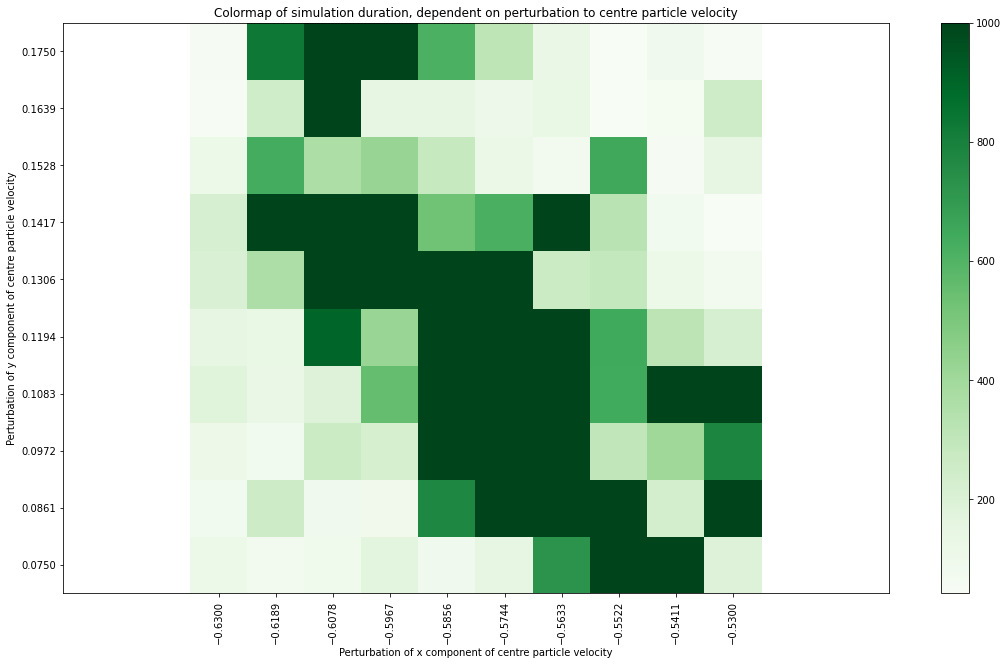

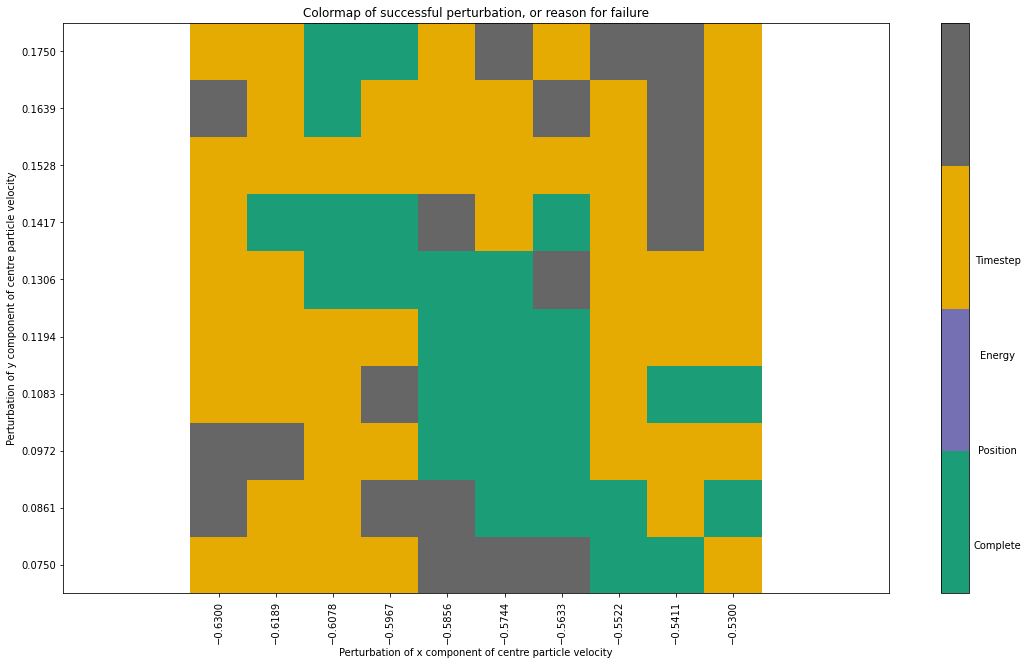

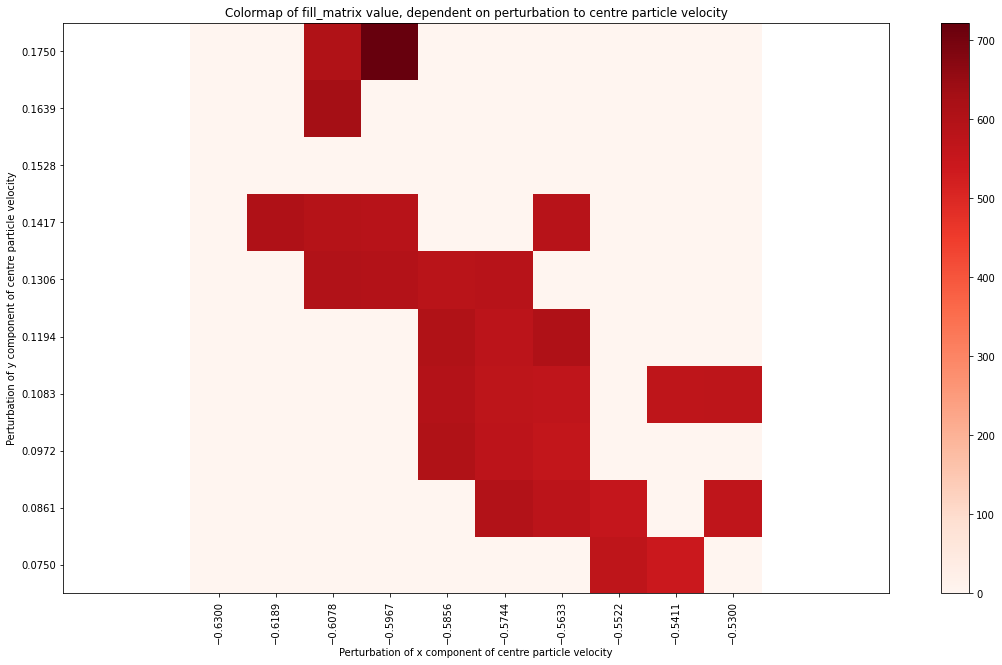

In [40]:
#### Plot duration before failure
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.axis('equal')
heatmap = ax.pcolormesh(perturb_x,perturb_y,np.transpose(time_until_failure),shading='nearest',cmap='Greens')
cbar = plt.colorbar(heatmap)
# put the major ticks at the middle of each cell
ax.set_xticks(perturb_x, minor=False)
plt.xticks(rotation = 90)
ax.set_yticks(perturb_y, minor=False)
plt.xlabel('Perturbation of x component of centre particle velocity') 
plt.ylabel('Perturbation of y component of centre particle velocity')
plt.title('Colormap of simulation duration, dependent on perturbation to centre particle velocity')
plt.show()

#### Plot reason for failure
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.axis('equal')
heatmap = ax.pcolormesh(perturb_x,perturb_y,np.transpose(failure_class),shading='nearest',cmap=plt.cm.get_cmap('Dark2', 4))
cbar = plt.colorbar(heatmap)
#legend
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['Complete','Position','Energy','Timestep']):
    cbar.ax.text(6, (4 * j + 2) / 8.0, lab, ha='center', va='center')
# put the major ticks at the middle of each cell
ax.set_xticks(perturb_x, minor=False)
plt.xticks(rotation = 90)
ax.set_yticks(perturb_y, minor=False)
plt.xlabel('Perturbation of x component of centre particle velocity') 
plt.ylabel('Perturbation of y component of centre particle velocity')
plt.title('Colormap of successful perturbation, or reason for failure')
plt.show()

#### Plot shape value for successful simulations
## Only plot fill_matrix value if the simulation was successful
fill_matrix_vals2 = fill_matrix_vals
fill_matrix_vals2[time_until_failure<1000] = 0 
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.axis('equal')
heatmap = ax.pcolormesh(perturb_x,perturb_y,np.transpose(fill_matrix_vals),shading='nearest',cmap='Reds')
cbar = plt.colorbar(heatmap)
# put the major ticks at the middle of each cell
ax.set_xticks(perturb_x, minor=False)
plt.xticks(rotation = 90)
ax.set_yticks(perturb_y, minor=False)
plt.xlabel('Perturbation of x component of centre particle velocity') 
plt.ylabel('Perturbation of y component of centre particle velocity')
plt.title('Colormap of fill_matrix value, dependent on perturbation to centre particle velocity')
plt.show()
